In [1]:
import numpy as np
import tensorflow as tf
import os
import json
import glob
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.model_selection
import tensorflow_addons as tfa
from gensim.models import Word2Vec, FastText
from typing import List, Tuple

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

__type = 'full'
# __type = 'pruned'

Num GPUs Available:  1


In [2]:
def read(path: str):
    balanced_labels = [
        'dp',
        'greedy',
        'implementation',
        'dfs and similar',
        'graphs',
        'brute force',
        'math',
        'number theory',
        'constructive algorithms',
        'trees',
        'binary search',
        'data structures',
        'two pointers',
        '*special',
        'sortings',
        'strings',
        'bitmasks',
        'combinatorics',
        'geometry',
    ]
    codes = []
    tags = []
    paths = []
    for i in tqdm.tqdm(glob.iglob(os.path.join(path, '*.json')), desc='Reading data', total=(len(os.listdir(path)) - 1) // 3):
        pre, ext = os.path.splitext(i)
        tags.append(list(filter(lambda tag: tag in balanced_labels, json.load(open(i, 'r', encoding='utf-8'))['Tags'])))
        statements = open(pre + '.java.ast.stm.flat', 'r', encoding='utf-8').read().strip('\n').split('\n\n')
        codes.append([])
        paths.append(i)
        for stm in statements:
            if len(stm) > 200:
                continue
            codes[-1].append([])
            for line in stm.split('\n'):
                try:
                    token, children = line.split('\t')
                    children = tuple(map(int, children.split())) if children else ()
                    codes[-1][-1].append((token, children))
                except Exception as e:
                    print(i)
                    print(line)
                    print()
                    print(stm)
                    raise e

    return codes, tags, paths

In [3]:
codes, tags, paths = read(f'../data/revisited/java/{__type}')

Reading data:   0%|          | 0/32358 [00:00<?, ?it/s]

In [4]:
for code, p in zip(codes, paths):
    for statement in code:
        for node, children in statement:
            for child in children:
                try:
                    _ = statement[child]
                except Exception as e:
                    print(p)
                    print(node)
                    print(child)
                    print(statement)
                    raise e

In [5]:
vocab = set()
for code in codes:
    for statement in code:
        for token, _ in statement:
            vocab.add(token)
vocab = list(vocab)
token_to_id = {j:i for i, j in enumerate(vocab)}
len(vocab)

46343

In [6]:
from collections import defaultdict

freq = defaultdict(int)
labels = set()
for tag_list in tags:
    for tag in tag_list:
        labels.add(tag)
        freq[tag] += 1
labels = list(labels)
label_to_id = {label: i for i, label in enumerate(labels)}

len(labels), freq

(19,
 defaultdict(int,
             {'dp': 8642,
              'greedy': 13835,
              'implementation': 20837,
              'dfs and similar': 3067,
              'graphs': 2986,
              'brute force': 7896,
              'math': 14851,
              'number theory': 5538,
              'constructive algorithms': 11079,
              'trees': 1945,
              'binary search': 2635,
              'data structures': 4172,
              'two pointers': 1612,
              '*special': 1852,
              'sortings': 4213,
              'strings': 4391,
              'bitmasks': 1299,
              'combinatorics': 1274,
              'geometry': 1237}))

In [7]:
sorted_labels = sorted(freq.keys())

In [81]:
balance = np.array([freq[i] for i in sorted_labels])
fracs = balance / balance.max()

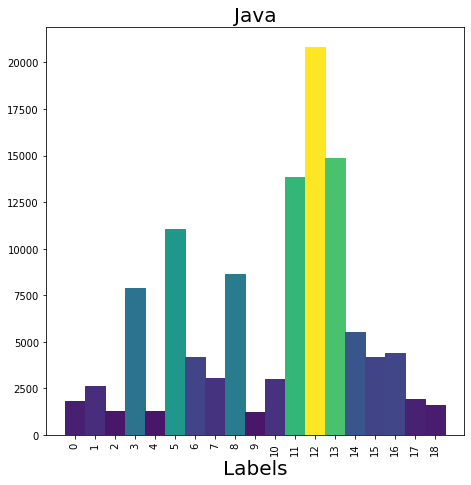

In [83]:
x = list(range(len(balance)))
plt.title('Java', fontsize=20)
plt.xlabel('Labels', fontsize=20)
plt.xticks(x, x, rotation=90)
#plt.ylabel('Count', fontsize=20)
#plt.grid(color = 'green', linestyle = '--', linewidth = 0.5, axis='y')
bars = plt.bar(x=x, height=balance, width=1)
for i in range(len(balance)):
    bars[i].set_color(plt.cm.viridis(fracs[i]))
fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.savefig('Java_code_distribution.png', dpi=600)
#plt.hist(balance, bins=len(balance))

# fig, axs = plt.subplots(1, 2, tight_layout=True)
#
# # N is the count in each bin, bins is the lower-limit of the bin
# N, bins, patches = axs[0].hist(x, bins=n_bins)
#
# # We'll color code by height, but you could use any scalar
# fracs = N / N.max()
#
# # we need to normalize the data to 0..1 for the full range of the colormap
# norm = colors.Normalize(fracs.min(), fracs.max())
#
# # Now, we'll loop through our objects and set the color of each accordingly
# for thisfrac, thispatch in zip(fracs, patches):
#     color = plt.cm.viridis(norm(thisfrac))
#     thispatch.set_facecolor(color)
#
# # We can also normalize our inputs by the total number of counts
# axs[1].hist(x, bins=n_bins, density=True)
#
# # Now we format the y-axis to display percentage
# axs[1].yaxis.set_major_formatter(PercentFormatter(xmax=1))

In [6]:
vector_size = 192

In [12]:
w2v_model = Word2Vec.load(f'../embeddings/revisited/java/{__type}/stm.w2v')
w2v_wv = w2v_model.wv
w2v_embeddings = np.array([w2v_wv[i] if i in w2v_wv else np.zeros((vector_size,)) for i in vocab])

In [7]:
ft_model = FastText.load(f'../embeddings/revisited/java/{__type}/stm.ft')
ft_wv = ft_model.wv
ft_embeddings = np.array([ft_wv[i] if i in ft_wv else np.zeros((vector_size,)) for i in vocab])

In [13]:
print(w2v_embeddings[0][:10])
print(ft_embeddings[0][:10])
print(sum(i in w2v_wv for i in vocab), len(vocab))
print(sum(i in ft_wv for i in vocab), len(vocab))
print(len(w2v_model.wv.key_to_index))
print(len(ft_model.wv.key_to_index))

[-0.00996109  0.01853905  0.04357075 -0.06149104  0.04350245  0.0757494
  0.10162805 -0.05165766  0.02721444 -0.12090312]
[-16.046976   -1.534591   20.914219    8.221931    1.2179637 -15.312166
 -40.591694   23.785963  -38.204758  -37.188934 ]
46343 46343
46343 46343
54385
54385


In [60]:
vectorized = []
indices = []
he_tags = []

statements_hist = []
nodes_hist = []
max_code_len = -1
max_statement_len = -1

for code in codes:
    vectorized.append([])
    indices.append([])
    max_code_len = max(max_code_len, len(code))
    statements_hist.append(len(code))
    for statement in code:
        vectorized[-1].append([])
        indices[-1].append([])
        max_statement_len = max(max_statement_len, len(statement))
        nodes_hist.append(len(statement))
        for token, _ in statement:
            vectorized[-1][-1].append(token_to_id[token] + 1)
            indices[-1][-1].append(_)

for tag_list in tags:
    he_tags.append([0] * len(labels))
    for tag in tag_list:
        he_tags[-1][label_to_id[tag]] = 1

In [9]:
print(vectorized[0])
print(indices[0])
print(he_tags[:3])

[[42904, 37495, 39348, 31392], [17598, 37495, 39348, 39579, 31813, 39348, 15407, 369, 39348, 27426, 38499], [20827, 27039, 39348, 31504, 26696, 39348, 28003], [20153, 13402, 7760, 39348, 13578], [20827, 27039, 39348, 31504, 26696, 39348, 43119, 32881, 19995, 23058], [16983, 6594, 27508, 12262, 17431, 45960, 39348, 28003, 32881, 19995, 23058, 6957], [24890, 6594, 27508, 12262, 34159, 45960, 39348, 28003, 6957, 6957], [20153, 13402, 20363, 39348, 34040, 6506, 32881, 19995, 23058], [40782, 13707, 12262, 17876, 45960, 39348, 28003], [20153, 13402, 20363, 39348, 34040, 6506, 32881, 19995, 23058], [40782, 45960, 39348, 43119, 41822, 30129, 12262, 33392], [20153, 13402, 20363, 39348, 31533, 6506, 32881, 19995, 23058], [20153, 13402, 43739, 39348, 11792, 6506, 45960, 39348, 43119]]
[[(1,), (2,), (3,), ()], [(1, 10), (2, 4), (3,), (), (5, 7), (6,), (), (8,), (9,), (), ()], [(1, 4), (2,), (3,), (), (5,), (6,), ()], [(1, 3), (2,), (), (4,), ()], [(1, 4), (2,), (3,), (), (5, 7), (6,), (), (8,), (9

51.72779663858502
999


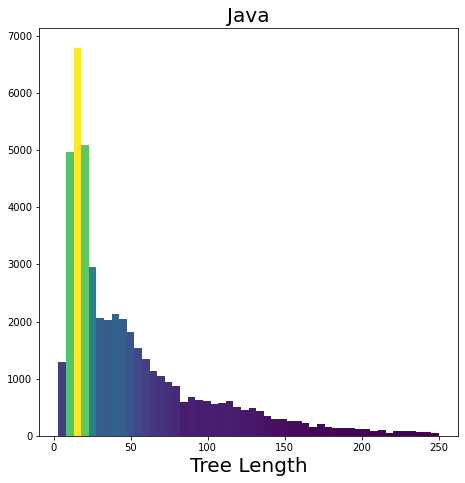

In [78]:
import matplotlib.colors as colors
statements_hist = list(filter(lambda x: x <= 250, statements_hist))
N, bins, patches = plt.hist(statements_hist, bins=50)
print(np.mean(statements_hist))
print(max_code_len)

fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
# x = list(range(len(balance)))
plt.title('Java', fontsize=20)
plt.xlabel('Tree Length', fontsize=20)
#plt.ylabel('Count', fontsize=20)
#plt.grid(color = 'green', linestyle = '--', linewidth = 0.5, axis='y')
# bars = plt.bar(x=x, height=balance, width=1)
# for i in range(len(balance)):
#     bars[i].set_color(plt.cm.viridis(fracs[i]))
fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.savefig('Java_statement_tree_lengths.png', dpi=600)

8.168198334526409
20


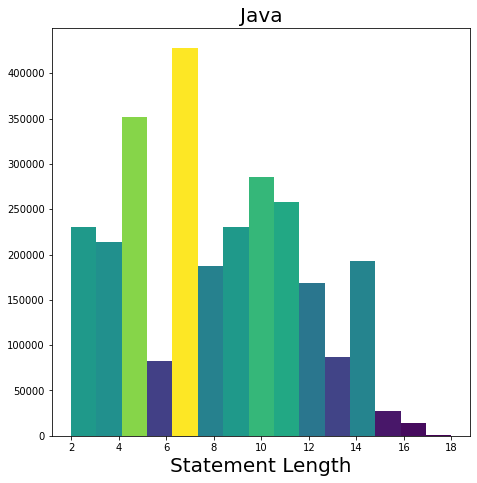

In [90]:
import matplotlib.colors as colors
nodes_hist = list(filter(lambda x: x <= 18, nodes_hist))
N, bins, patches = plt.hist(nodes_hist, bins=15, align='mid')
print(np.mean(nodes_hist))
print(max_statement_len)

fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
# x = list(range(len(balance)))
plt.title('Java', fontsize=20)
plt.xlabel('Statement Length', fontsize=20)
# plt.ylabel('Count', fontsize=20)
#plt.grid(color = 'green', linestyle = '--', linewidth = 0.5, axis='y')
# bars = plt.bar(x=x, height=balance, width=1)
# for i in range(len(balance)):
#     bars[i].set_color(plt.cm.viridis(fracs[i]))
fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.savefig('Java_statement_lengths.png', dpi=600)

In [97]:
cpp_labels_d = defaultdict(int)
with open('codek_labels.txt', 'r', encoding='utf-8') as fp:
    asd = fp.read().strip().split('\n')
    for line in asd:
        l, f = line.split('\t')
        cpp_labels_d[l] = float(f)

cpp_labels = list(sorted(cpp_labels_d.keys()))
cpp_freqs = np.array([cpp_labels_d[i] for i in cpp_labels])
fracs = cpp_freqs / cpp_freqs.max()

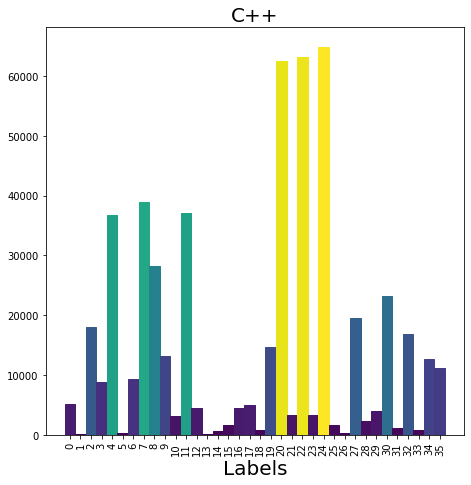

In [98]:
x = list(range(len(cpp_labels)))
plt.title('C++', fontsize=20)
plt.xlabel('Labels', fontsize=20)
plt.xticks(x, x, rotation=90)
#plt.ylabel('Count', fontsize=20)
#plt.grid(color = 'green', linestyle = '--', linewidth = 0.5, axis='y')
bars = plt.bar(x=x, height=cpp_freqs, width=1)
for i in range(len(cpp_freqs)):
    bars[i].set_color(plt.cm.viridis(fracs[i]))
fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.savefig('C++_code_distribution.png', dpi=600)

In [99]:
lens = np.array(list(map(int, open('lens.txt', 'r', encoding='utf-8').readline().strip().split(' '))))

410.85045430251205
2000


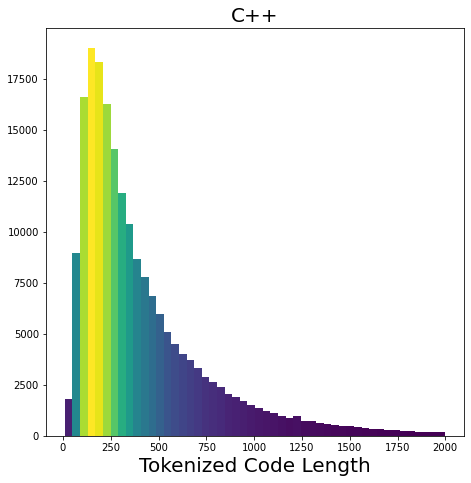

In [102]:
import matplotlib.colors as colors
lens = np.array(list(filter(lambda x: x <= 2000, lens)))
N, bins, patches = plt.hist(lens, bins=50, align='mid')
print(np.mean(lens))
print(lens.max())

fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)
# x = list(range(len(balance)))
plt.title('C++', fontsize=20)
plt.xlabel('Tokenized Code Length', fontsize=20)
# plt.ylabel('Count', fontsize=20)
#plt.grid(color = 'green', linestyle = '--', linewidth = 0.5, axis='y')
# bars = plt.bar(x=x, height=balance, width=1)
# for i in range(len(balance)):
#     bars[i].set_color(plt.cm.viridis(fracs[i]))
fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.savefig('C++_tokenized_lengths.png', dpi=600)

In [ ]:
def get_embedding(shape: tuple, vocab: list, input_size: int, output_size: int, shift: int = 0, pre_trained = None):
    embedding = tf.keras.layers.Embedding(input_size, output_size, name='Tree_Embedding', mask_zero=True)
    embedding.build(shape)
    embedding.trainable = pre_trained is None
    if pre_trained is not None:
        weights = np.zeros((input_size, output_size))
        for i, token in enumerate(vocab):
            try:
                weights[i + shift] = pre_trained[i]
            except:
                pass
        embedding.set_weights([weights])
    return embedding


def get_embedding_encoder(input_shape: tuple, output_size: int):
    inputs = tf.keras.layers.Input(input_shape)
    outputs = tf.keras.layers.Dense(output_size)(inputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name='Embedding_Encoder')


def get_statement_encoder(input_shape: tuple, filters: int):
    inputs = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Lambda(lambda tensor: tf.math.reduce_max(tensor, axis=2))(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name='Statement_Encoder')


def get_tree_encoder(input_shape: tuple, predict: bool = False, backbone: str = 'rnn'):
    inputs = tf.keras.layers.Input(input_shape, name='Inputs')
    dropout = tf.keras.layers.Dropout(0.1, name='Embedding_Dropout')(inputs)
    if backbone == 'rnn':
        x = tf.keras.layers.Bidirectional(
                tf.keras.layers.RNN(tf.keras.layers.GRUCell(units=128)),
            name='Double_Bidirectional_GRU')(dropout)
    else:
        n_layers = 2
        kernels = [3, 5, 7]
        layers = []
        for k in kernels:
            x = dropout
            n = x.shape[-1]
            for i in range(n_layers):
                x = tf.keras.layers.Conv1D(n, k, activation=tf.keras.activations.swish, padding='same', name=f'Conv1D_{k}_{n}')(x)
                x = tf.keras.layers.BatchNormalization(name=f'Batch_Norm_{k}_{n}')(x)
                n *= 2
            x = tf.keras.layers.GlobalMaxPooling1D(name=f'Max_Pool_{k}')(x)
            layers.append(x)
        x = tf.keras.layers.Concatenate(axis=-1, name='Pool_Concatenate')(layers)
        x = tf.keras.layers.Dropout(0.2, name='Concatenate_Dropout')(x)
    if predict:
        x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='Prediction')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x, name='Tree_Encoder')

In [11]:
class StatementDataset(tf.keras.utils.Sequence):
    def __init__(self, vectorized, indices, he_tags, batch_size):
        self.vectorized = vectorized
        self.indices = indices
        self.he_tags = he_tags
        self.batch_size = batch_size
        self.shuffle()

    def __len__(self):
        return (len(self.vectorized) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        vectorized_batch = self.vectorized[start:end]
        indices_batch = self.indices[start:end]
        he_tags_batch = self.he_tags[start:end]

        max_len = max(len(j) for i in vectorized_batch for j in i)
        code_batch = tf.keras.preprocessing.sequence.pad_sequences(
            [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
            padding='post'
        )
        code_batch = code_batch[:,1:129]
        indices_batch = [[i[j] for j in range(1, min(129, len(i)))] for i in indices_batch]
        return (code_batch, indices_batch), he_tags_batch

    def shuffle(self):
        indices = np.arange(len(self.vectorized))
        np.random.shuffle(indices)

        self.vectorized = [self.vectorized[i] for i in indices]
        self.indices = [self.indices[i] for i in indices]
        self.he_tags = [self.he_tags[i] for i in indices]

    def on_epoch_end(self):
        self.shuffle()

In [12]:
shift = 1
emb_input_size = len(vocab) + shift
emb_output_size = 192
emb_encoder_output_size = 128
backbone = 'cnn'
path = f'java_statements_model_revisited/{backbone}'

def calc_logits(code_batch, indices_batch, embedding, embedding_encoder_model, tree_encoder_model):
    # b: code_batch length
    # n: code_batch.shape[1] -- number of sequences in code
    # m: code_batch.shape[2] -- number of statements in sequence
    # e: embedding vector size
    # code_batch: (b, n, m,)
    # encoded: (b, n, m, e,)
    encoded = embedding_encoder_model(embedding(code_batch), training=True)
    encoded_as_list = [[[encoded[i, j, k] for k in range(code_batch.shape[2])] for j in range(code_batch.shape[1])] for i in range(len(code_batch))]
    # statement encoding over known embeddings
    for i in range(len(indices_batch)):
        for j in range(len(indices_batch[i])):
            for k in range(len(indices_batch[i][j]) - 1, -1, -1):
                children = indices_batch[i][j][k]
                if not children:
                    continue
                encoded_as_list[i][j][k] = tf.reduce_sum([
                    encoded_as_list[i][j][k],
                    *(encoded_as_list[i][j][l] for l in children)
                ], axis=0)
    pooled = tf.math.reduce_max(encoded_as_list, axis=2)
    logits = tree_encoder_model(pooled, training=True)
    return logits


def calc_loss(y_true, y_pred, metrics=None):
    metrics = metrics or []
    loss = tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    for metric in metrics:
        metric.update_state(y_true, y_pred)
    return loss


def tree_encoding_step(optimizer, code_batch, indices_batch, he_tags_batch, metrics):
    with tf.GradientTape() as tape:
        logits = calc_logits(code_batch, indices_batch,
                             embedding, embedding_encoder_model, tree_encoder_model)
        loss = calc_loss(he_tags_batch, logits, metrics)
        trainable_weights = tree_encoder_model.trainable_weights + embedding_encoder_model.trainable_weights
    grads = tape.gradient(loss, trainable_weights)
    optimizer.apply_gradients(zip(grads, trainable_weights))
    return loss


def models_parallel_train(epochs: int, batch_size: int):
    # split data
    vectorized_train, vectorized_test, \
    indices_train, indices_test, \
    he_tags_train, he_tags_test = \
        sklearn.model_selection.train_test_split(vectorized,
                                                 indices,
                                                 he_tags)

    # create datasets
    train_dataset = StatementDataset(vectorized_train, indices_train, he_tags_train, batch_size=batch_size)
    test_dataset = StatementDataset(vectorized_test, indices_test, he_tags_test, batch_size=batch_size)

    # create handlers for logging
    os.makedirs(path, exist_ok=True)
    train_loss_log = open(os.path.join(path, 'train_loss.txt'), 'w', encoding='utf-8')
    train_f1_log   = open(os.path.join(path, 'train_f1.txt'),   'w', encoding='utf-8')
    test_loss_log  = open(os.path.join(path, 'test_loss.txt'),  'w', encoding='utf-8')
    test_f1_log    = open(os.path.join(path, 'test_f1.txt'),    'w', encoding='utf-8')

    try:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=2e-3)
        metrics = [tfa.metrics.F1Score(len(labels), average='macro')]
        for epoch in tqdm.trange(epochs):

            #train
            loss = 0
            pbar = tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset))
            for step, ((code_batch, indices_batch), he_tags_batch) in pbar:
                loss_value = tree_encoding_step(optimizer,
                                                code_batch,
                                                indices_batch,
                                                he_tags_batch,
                                                metrics)
                loss += loss_value.numpy()
                mean_loss = f'{loss / (step + 1):.3f}'
                f1_score = f'{metrics[0].result().numpy():.3f}'
                pbar.set_description(f'[TRAIN] | Loss: {mean_loss}; F1: {f1_score}')
                if step % 100 == 0:
                    train_loss_log.write(f'{mean_loss} ')
                    train_f1_log.write(f'{f1_score} ')
            train_loss_log.write('\n')
            train_f1_log.write('\n')

            # save
            embedding_encoder_model.save(os.path.join(path, f'embedding_encoder_weights_{total_epochs + epoch}'))
            tree_encoder_model.save(os.path.join(path, f'statement_tree_encoder_weights_{total_epochs + epoch}'))

            # reset metrics
            for metric in metrics:
                metric.reset_state()

            # test
            loss = 0
            pbar = tqdm.tqdm(enumerate(test_dataset), total=len(test_dataset))
            for step, ((code_batch, indices_batch), he_tags_batch) in pbar:
                logits = calc_logits(code_batch, indices_batch,
                                     embedding, embedding_encoder_model, tree_encoder_model)
                loss_value = calc_loss(he_tags_batch, logits, metrics)
                loss += loss_value.numpy()
                mean_loss = f'{loss / (step + 1):.3f}'
                f1_score = f'{metrics[0].result().numpy():.3f}'
                pbar.set_description(f'[TEST] | Loss: {mean_loss}; F1: {f1_score}')

            test_loss_log.write(f'{loss / len(test_dataset)}\n')
            test_f1_log.write(f'{metrics[0].result().numpy():.3f}\n')

            # reset metrics
            for metric in metrics:
                metric.reset_state()

            train_loss_log.flush()
            train_f1_log.flush()
            test_loss_log.flush()
            test_f1_log.flush()
            train_dataset.on_epoch_end()
    finally:
        train_loss_log.close()
        train_f1_log.close()
        test_loss_log.close()
        test_f1_log.close()


embedding = get_embedding(shape=(None, None, None),
                          input_size=emb_input_size,
                          output_size=emb_output_size,
                          pre_trained=ft_embeddings,
                          shift=1,
                          vocab=vocab)
embedding_encoder_model = get_embedding_encoder(input_shape=(None, None, emb_output_size),
                                                output_size=emb_encoder_output_size)
tree_encoder_model = get_tree_encoder(input_shape=(None, emb_encoder_output_size),
                                      predict=True, backbone=backbone)

total_epochs = 0

In [69]:
# total_epochs = 4
# embedding_encoder_model = tf.keras.models.load_model(f'{path}/embedding_encoder_weights_{total_epochs - 1}')
# tree_encoder_model = tf.keras.models.load_model(f'{path}/statement_tree_encoder_weights_{total_epochs - 1}')

In [13]:
models_parallel_train(epochs=5, batch_size=4)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_0\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_0\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_0\assets
d:\git\yepcode\venv\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


  0%|          | 0/3034 [00:00<?, ?it/s]

  0%|          | 0/9101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_1\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_1\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_1\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_1\assets
d:\git\yepcode\venv\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


  0%|          | 0/3034 [00:00<?, ?it/s]

  0%|          | 0/9101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_2\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_2\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_2\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_2\assets
d:\git\yepcode\venv\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


  0%|          | 0/3034 [00:00<?, ?it/s]

  0%|          | 0/9101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_3\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_3\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_3\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_3\assets
d:\git\yepcode\venv\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


  0%|          | 0/3034 [00:00<?, ?it/s]

  0%|          | 0/9101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_4\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_4\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_4\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_4\assets
d:\git\yepcode\venv\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


  0%|          | 0/3034 [00:00<?, ?it/s]

In [38]:
total = 0
correct = 0
vectorized_train, vectorized_test, \
indices_train, indices_test, \
he_tags_train, he_tags_test = \
    sklearn.model_selection.train_test_split(vectorized,
                                             indices,
                                             he_tags)

train_dataset = StatementDataset(vectorized_train, indices_train, he_tags_train, batch_size=2)
test_dataset = StatementDataset(vectorized_test, indices_test, he_tags_test, batch_size=2)

In [39]:
y_true = []
y_pred = []
pbar = tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset))
for step, ((cbatch, ibatch), hetbatch) in pbar:
    y_pred_batch = calc_logits(cbatch, ibatch,
                               embedding, embedding_encoder_model, tree_encoder_model)
    for i in range(len(y_pred_batch)):
        _y_true = np.array(hetbatch[i])
        _y_pred = y_pred_batch[i].numpy()
        y_true.extend(_y_true)
        y_pred.extend(_y_pred)

  0%|          | 0/18201 [00:00<?, ?it/s]

In [172]:
def calc_metrics(y_true: np.ndarray, y_pred: np.ndarray, thresholds: list = None, threshold_count: int = 100):
    total = len(y_true)
    thresholds = thresholds or list(np.linspace(0, 1, threshold_count))
    metrics = []

    positives = y_true.sum()
    negatives = total - positives
    for threshold in thresholds:
        p = y_pred > threshold
        t = y_true.astype(bool)

        tp = np.logical_and(p, t).sum()
        tn = np.logical_and(np.logical_not(p), np.logical_not(t)).sum()
        fp = np.logical_and(p, np.logical_not(t)).sum()
        fn = np.logical_and(np.logical_not(p), t).sum()

        tpr = tp / positives
        tnr = tn / negatives
        precision = tp / (tp + fp) if tp + fp else 0
        recall = tp / (tp + fn) if tp + fn else 0
        accuracy = (tp + tn) / (tp + fn + tn + fp)
        f1 = 2 * precision * recall / (precision + recall) if precision or recall else 0

        metrics.append({
            'threshold': round(threshold, 3),
            'tpr': round(tpr, 3),
            'tnr': round(tnr, 3),
            'precision': round(precision, 3),
            'recall': round(recall, 3),
            'accuracy': round(accuracy, 3),
            'f1': round(f1, 3)
        })

    return metrics


def calc_rocauc(metrics):
    coords = [(i['tpr'], i['tnr']) for i in metrics]
    auc = 0
    for i in range(len(coords) - 1):
        coord_i = coords[i]
        coord_j = coords[i + 1]
        auc += (coord_i[0] + coord_j[0]) / 2 * (coord_j[1] - coord_i[1])
    return coords, auc

In [43]:
y_true_np = np.array(y_true).reshape(-1, len(labels))
y_pred_np = np.array(y_pred).reshape(-1, len(labels))

Thresholds:
0.055
0.043
0.020999999999999998
0.416
0.205
0.023
0.065
0.179
0.143
0.035
0.009000000000000001
0.020999999999999998
0.105
0.109
0.173
0.185
0.015
0.027
0.027

Train metrics:
Precision: 0.2781
Recall: 0.7625
Accuracy: 0.7639
F1: 0.3813



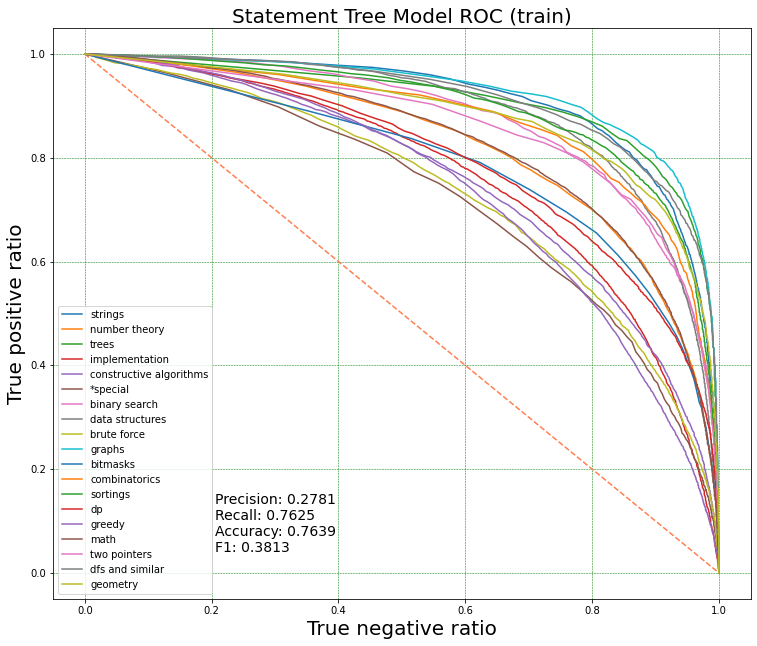

In [208]:
metrics_for_predicted = [calc_metrics(y_true_np[:,i], y_pred_np[:,i], threshold_count=500) for i in range(len(labels))]

plt.title('Statement Tree Model ROC (train)', fontsize=20)
plt.xlabel('True negative ratio', fontsize=20)
plt.ylabel('True positive ratio', fontsize=20)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.plot([0, 1], [1, 0], '--', color='coral')
l = 0
for metric_batch in metrics_for_predicted:
    coords, auc = calc_rocauc(metric_batch)
    plt.plot([i[1] for i in coords], [i[0] for i in coords], label=labels[l])
    l += 1
plt.legend()
thresholds = []
for metric_batch in metrics_for_predicted:
    last_threshold = 0
    for metrics in metric_batch:
        tpr = metrics['tpr']
        tnr = metrics['tnr']
        if tnr > tpr:
            thresholds.append((last_threshold + metrics['threshold']) / 2)
            break
        last_threshold = metrics['threshold']

metrics_for_predicted_with_thresholds = [calc_metrics(y_true_np[:,i], y_pred_np[:,i], thresholds=[thresholds[i]]) for i in range(len(labels))]

total_mean_metrics = defaultdict(float)
for metrics in metrics_for_predicted_with_thresholds:
    total_mean_metrics['precision'] += metrics[0]['precision']
    total_mean_metrics['recall'] += metrics[0]['recall']
    total_mean_metrics['accuracy'] += metrics[0]['accuracy']
    total_mean_metrics['f1'] += metrics[0]['f1']

for key in total_mean_metrics.keys():
    total_mean_metrics[key] /= len(labels)

s_t = '\n'.join(map(str, thresholds))
s_m = '\n'.join(map(lambda x: f'{str.upper(x[0]) + x[1:]}: {round(total_mean_metrics[x], 4)}', total_mean_metrics))
print(f'Thresholds:\n{s_t}\n\nTrain metrics:\n{s_m}\n')
plt.text(0.205, 0.04, s_m, fontsize=14)
fig = plt.gcf()
fig.set_size_inches(12.5, 10.5)
fig.savefig('S_T_M_ROC_200_500_train_labeled.png', dpi=200)

  0%|          | 0/6068 [00:00<?, ?it/s]

In [ ]:
y_true_test = []
y_pred_test = []
pbar = tqdm.tqdm(enumerate(test_dataset), total=len(test_dataset))
for step, ((cbatch, ibatch), hetbatch) in pbar:
    y_pred_batch = calc_logits(cbatch, ibatch,
                               embedding, embedding_encoder_model, tree_encoder_model)
    for i in range(len(y_pred_batch)):
        _y_true = np.array(hetbatch[i])
        _y_pred = y_pred_batch[i].numpy()
        y_true_test.extend(_y_true)
        y_pred_test.extend(_y_pred)

In [175]:
y_true_test_np = np.array(y_true_test).reshape(-1, len(labels))
y_pred_test_np = np.array(y_pred_test).reshape(-1, len(labels))

Test metrics:
Accuracy: 0.7634
Precision: 0.2725
Recall: 0.7336
F1: 0.3676



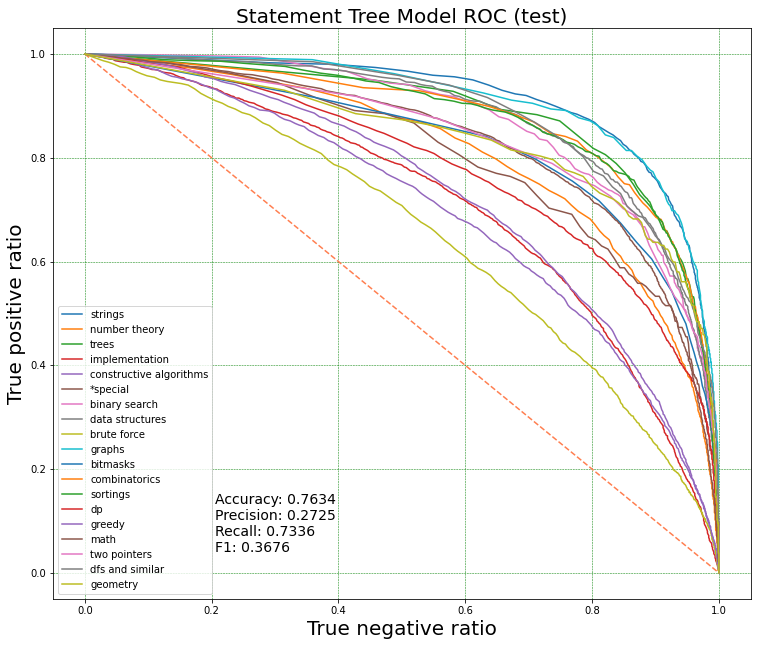

In [206]:
metrics_for_predicted_test = [calc_metrics(y_true_test_np[:,i], y_pred_test_np[:,i], threshold_count=500) for i in range(len(labels))]

plt.title('Statement Tree Model ROC (test)', fontsize=20)
plt.xlabel('True negative ratio', fontsize=20)
plt.ylabel('True positive ratio', fontsize=20)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
plt.plot([0, 1], [1, 0], '--', color='coral')
l = 0
for metric_batch in metrics_for_predicted_test:
    coords, auc = calc_rocauc(metric_batch)
    plt.plot([i[1] for i in coords], [i[0] for i in coords], label=labels[l])
    l += 1
plt.legend()

metrics_for_predicted_test_with_thresholds = [calc_metrics(y_true_test_np[:,i], y_pred_test_np[:,i], thresholds=[thresholds[i]]) for i in range(len(labels))]

total_mean_test_metrics = defaultdict(float)
for metrics in metrics_for_predicted_test_with_thresholds:
    total_mean_test_metrics['accuracy'] += metrics[0]['accuracy']
    total_mean_test_metrics['precision'] += metrics[0]['precision']
    total_mean_test_metrics['recall'] += metrics[0]['recall']
    total_mean_test_metrics['f1'] += metrics[0]['f1']

for key in total_mean_test_metrics.keys():
    total_mean_test_metrics[key] /= len(labels)

s_m = '\n'.join(map(lambda x: f'{str.upper(x[0]) + x[1:]}: {round(total_mean_test_metrics[x], 4)}', total_mean_test_metrics))
print(f'Test metrics:\n{s_m}\n')
plt.text(0.205, 0.04, s_m, fontsize=14)
fig = plt.gcf()
fig.set_size_inches(12.5, 10.5)
fig.savefig('S_T_M_ROC_200_500_test_labeled.png', dpi=200)

In [ ]:
# total = 0
# instances = np.zeros(len(labels))
# correct_instances = np.zeros(len(labels))
# tp = np.zeros(len(labels))
# tn = np.zeros(len(labels))
# fp = np.zeros(len(labels))
# fn = np.zeros(len(labels))
#
# for (code_batch, indices_batch), he_tags_batch in test_dataset:
#     y_pred_batch = calc_logits(code_batch, indices_batch, embedding, embedding_encoder_model, tree_encoder_model)
#     for i in range(len(y_pred_batch)):
#         y_pred = y_pred_batch[i].numpy().round(2) > 0.5
#         y_true = np.array(he_tags_batch[i]) > 0.5
#         for j in range(len(y_pred)):
#             total += 1
#             instances[j] += 1
#             cmp = y_pred[j] == y_true[j]
#             correct_instances[j] += cmp
#             tp[j] += (cmp == True and y_pred[j] == 1)
#             tn[j] += (cmp == True and y_pred[j] == 0)
#             fp[j] += (cmp == False and y_pred[j] == 1)
#             fn[j] += (cmp == False and y_pred[j] == 0)

In [25]:
# emr = correct_instances.sum() / total
# precision = (tp / (tp + fp)).mean()
# recall = (tp / (tp + fn)).mean()
# accuracy = ((tp + tn) / (tp + fn + tn + fp)).mean()
# f1 = 2 * precision * recall / (precision + recall)
#
# print(f'Exact Match Ratio: {emr:.3f}')
# print(f'Precision: {precision:.3f}')
# print(f'Recall: {recall:.3f}')
# print(f'Accuracy: {accuracy:.3f}')
# print(f'F1: {f1:.3f}')

Exact Match Ratio: 0.892
Precision: 0.708
Recall: 0.236
Accuracy: 0.892
F1: 0.354


In [ ]:
# class StatementTreeModel:
#     def __init__(self, codes, tags, name: str = 'STM'):
#         self.name = name
#         self.epochs = 0
#         self.embedding_layer = None
#         self.embedding_encoder = None
#         self.tree_encoder = None
#         self.optimizer = None
#
#         vocab = set()
#         for code in codes:
#             for statement in code:
#                 for token, _ in statement:
#                     vocab.add(token)
#         self.__vocab = list(vocab)
#         self.__token_to_id = {j:i for i, j in enumerate(vocab)}
#
#         labels = set()
#         for tag_list in tags:
#             for tag in tag_list:
#                 labels.add(tag)
#         self.__labels = list(labels)
#         self.__label_to_id = {label: i for i, label in enumerate(labels)}
#
#         vectorized, indices, he_tags = [], [], []
#
#         # vectorize code, split tokens and children indices
#         for code in codes:
#             vectorized.append([])
#             indices.append([])
#             for statement in code:
#                 vectorized[-1].append([])
#                 indices[-1].append([])
#                 for token, _ in statement:
#                     vectorized[-1][-1].append(self.__token_to_id[token] + 1)
#                     indices[-1][-1].append(_)
#
#         # labels hot-encoding
#         for tag_list in tags:
#             he_tags.append([0] * len(labels))
#             for tag in tag_list:
#                 he_tags[-1][self.__label_to_id[tag]] = 1
#
#         # split data
#         self.__vectorized_train, self.__vectorized_test, \
#         self.__indices_train, self.__indices_test, \
#         self.__he_tags_train, self.__he_tags_test = \
#             sklearn.model_selection.train_test_split(vectorized,
#                                                      indices,
#                                                      he_tags)
#
#         # load embeddings
#         self.__vocab_shift = 1
#         self.__embedding_input_size = len(vocab) + shift
#         self.__embedding_output_size = 192
#         self.__embedding_encoder_output_size = 128
#         self.__embeddings = {'w2v': Word2Vec, 'ft': FastText}
#         for emb in self.__embeddings.keys():
#             model = self.__embeddings[emb].load(f'../embeddings/revisited/java/full/stm.{emb}')
#             wv = model.wv
#             self.__embeddings[emb] = np.array([wv[i] if i in wv else np.zeros((self.__embedding_output_size,)) for i in vocab])
#
#     def __create_embedding_layer(self, pre_trained = None):
#         embedding = tf.keras.layers.Embedding(self.__embedding_input_size, self.__embedding_output_size,
#                                               name='Tree_Embedding', mask_zero=True)
#         embedding.build((None, None, None))
#         embedding.trainable = pre_trained is None
#         if pre_trained is not None:
#             weights = np.zeros((self.__embedding_input_size, self.__embedding_output_size))
#             for i, token in enumerate(self.__vocab):
#                 try:
#                     weights[i + shift] = pre_trained[i]
#                 except:
#                     pass
#             embedding.set_weights([weights])
#         return embedding
#
#     def __create_embedding_encoder(self):
#         inputs = tf.keras.layers.Input((None, None, self.__embedding_output_size))
#         outputs = tf.keras.layers.Dense(self.__embedding_encoder_output_size)(inputs)
#         return tf.keras.Model(inputs=inputs, outputs=outputs, name='Embedding_Encoder')
#
#     def __create_tree_encoder(self, backbone: str = 'cnn'):
#         inputs = tf.keras.layers.Input((None, self.__embedding_encoder_output_size), name='Inputs')
#         dropout = tf.keras.layers.Dropout(0.2, name='Embedding_Dropout')(inputs)
#         if backbone == 'rnn':
#             x = tf.keras.layers.Bidirectional(
#                     tf.keras.layers.RNN(tf.keras.layers.GRUCell(units=128)),
#                 name='Double_Bidirectional_GRU')(dropout)
#         else:
#             n_layers = 4
#             kernels = [3, 5, 7]
#             layers = []
#             for k in kernels:
#                 x = dropout
#                 n = x.shape[-1]
#                 for i in range(n_layers):
#                     x = tf.keras.layers.Conv1D(n, k, activation=tf.keras.activations.swish, padding='same', name=f'Conv1D_{k}_{n}')(x)
#                     x = tf.keras.layers.BatchNormalization(name=f'Batch_Norm_{k}_{n}')(x)
#                     n *= 2
#                 x = tf.keras.layers.GlobalMaxPooling1D(name=f'Max_Pool_{k}')(x)
#                 layers.append(x)
#             x = tf.keras.layers.Concatenate(axis=-1, name='Pool_Concatenate')(layers)
#             x = tf.keras.layers.Dropout(0.2, name='Concatenate_Dropout')(x)
#         x = tf.keras.layers.Dense(units=512, activation=tf.keras.activations.swish, name=f'Dense')(x)
#         x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='Prediction')(x)
#         return tf.keras.models.Model(inputs=inputs, outputs=x, name='Tree_Encoder')
#
#     def calc_logits(self, code_batch, indices_batch):
#         # b: code_batch length
#         # n: code_batch.shape[1] -- number of sequences in code
#         # m: code_batch.shape[2] -- number of statements in sequence
#         # e: embedding vector size
#         # code_batch: (b, n, m,)
#         # encoded: (b, n, m, e,)
#         encoded = self.embedding_encoder(self.embedding_layer(code_batch), training=True)
#         encoded_as_list = [[[encoded[i, j, k]
#                              for k in range(code_batch.shape[2])]
#                             for j in range(code_batch.shape[1])]
#                            for i in range(len(code_batch))]
#         # statement encoding over known embeddings
#         for i in range(len(indices_batch)):
#             for j in range(len(indices_batch[i])):
#                 for k in range(len(indices_batch[i][j]) - 1, -1, -1):
#                     children = indices_batch[i][j][k]
#                     if not children:
#                         continue
#                     encoded_as_list[i][j][k] = tf.reduce_sum([
#                         encoded_as_list[i][j][k],
#                         *(encoded_as_list[i][j][l] for l in children)
#                     ], axis=0)
#         pooled = tf.math.reduce_max(encoded_as_list, axis=2)
#         logits = self.tree_encoder(pooled, training=True)
#         return logits
#
#
#     def __calc_loss(self, y_true, y_pred, metrics=None):
#         metrics = metrics or []
#         loss = tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
#         for metric in metrics:
#             metric.update_state(y_true, y_pred)
#         return loss
#
#
#     def __tree_encoding_step(self, code_batch, indices_batch, he_tags_batch, metrics):
#         with tf.GradientTape() as tape:
#             logits = self.calc_logits(code_batch, indices_batch)
#             loss = self.__calc_loss(he_tags_batch, logits, metrics)
#             trainable_weights = self.tree_encoder.trainable_weights + self.embedding_encoder.trainable_weights
#         grads = tape.gradient(loss, trainable_weights)
#         self.optimizer.apply_gradients(zip(grads, trainable_weights))
#         return loss
#
#     def compile(self, backbone='cnn', lr=1e-5, embeddings: str = None):
#         pre_trained = self.__embeddings.get(embeddings, None)
#         self.optimizer = tf.keras.optimizers.Adamax(learning_rate=lr)
#         self.embedding_layer = self.__create_embedding_layer(pre_trained=pre_trained)
#         self.embedding_encoder = self.embedding_encoder or self.__create_embedding_encoder()
#         self.tree_encoder = self.tree_encoder or self.__create_tree_encoder(backbone=backbone)
#
#     def load(self, embedding_encoder_weights_path, tree_encoder_weights_path):
#         self.embedding_encoder = tf.keras.models.load_model(f'{embedding_encoder_weights_path}')
#         self.tree_encoder = tf.keras.models.load_model(f'{tree_encoder_weights_path}')
#
#     def fit(self, epochs, batch_size):
#         # create datasets
#         train_dataset = StatementDataset(self.__vectorized_train, self.__indices_train, self.__he_tags_train,
#                                          batch_size=batch_size)
#         test_dataset = StatementDataset(self.__vectorized_test, self.__indices_test, self.__he_tags_test,
#                                         batch_size=batch_size)
#
#         # create logging handlers
#         os.makedirs(self.name, exist_ok=True)
#         train_loss_log = open(os.path.join(self.name, 'train_loss.txt'), 'w', encoding='utf-8')
#         train_f1_log   = open(os.path.join(self.name, 'train_f1.txt'),   'w', encoding='utf-8')
#         test_loss_log  = open(os.path.join(self.name, 'test_loss.txt'),  'w', encoding='utf-8')
#         test_f1_log    = open(os.path.join(self.name, 'test_f1.txt'),    'w', encoding='utf-8')
#         metrics = [tfa.metrics.F1Score(len(labels), average='macro')]
#
#         try:
#             for epoch in tqdm.trange(epochs):
#
#                 #train
#                 loss = 0
#                 pbar = tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset))
#                 for step, ((code_batch, indices_batch), he_tags_batch) in pbar:
#                     loss_value = self.__tree_encoding_step(code_batch, indices_batch, he_tags_batch,
#                                                            metrics)
#                     loss += loss_value.numpy()
#                     mean_loss = f'{loss / (step + 1):.3f}'
#                     f1_score = f'{metrics[0].result().numpy():.3f}'
#                     pbar.set_description(f'[TRAIN {self.epochs + epoch}/{self.epochs + epochs}] | Loss: {mean_loss}; F1: {f1_score}')
#                     if step % 100 == 0:
#                         train_loss_log.write(f'{mean_loss} ')
#                         train_f1_log.write(f'{f1_score} ')
#                 train_loss_log.write('\n')
#                 train_f1_log.write('\n')
#
#                 # save
#                 self.embedding_encoder.save(os.path.join(self.name, f'embedding_encoder_weights_{total_epochs + epoch}'))
#                 self.tree_encoder.save(os.path.join(self.name, f'statement_tree_encoder_weights_{total_epochs + epoch}'))
#
#                 # reset metrics
#                 for metric in metrics:
#                     metric.reset_state()
#
#                 # test
#                 loss = 0
#                 pbar = tqdm.tqdm(enumerate(test_dataset), total=len(test_dataset))
#                 for step, ((code_batch, indices_batch), he_tags_batch) in pbar:
#                     logits = self.calc_logits(code_batch, indices_batch)
#                     loss_value = self.__calc_loss(he_tags_batch, logits, metrics)
#                     loss += loss_value.numpy()
#                     mean_loss = f'{loss / (step + 1):.3f}'
#                     f1_score = f'{metrics[0].result().numpy():.3f}'
#                     pbar.set_description(f'[TEST] | Loss: {mean_loss}; F1: {f1_score}')
#
#                 test_loss_log.write(f'{loss / len(test_dataset)}\n')
#                 test_f1_log.write(f'{metrics[0].result().numpy():.3f}\n')
#
#                 # reset metrics
#                 for metric in metrics:
#                     metric.reset_state()
#
#                 train_loss_log.flush()
#                 train_f1_log.flush()
#                 test_loss_log.flush()
#                 test_f1_log.flush()
#                 train_dataset.on_epoch_end()
#                 test_dataset.on_epoch_end()
#         finally:
#             train_loss_log.close()
#             train_f1_log.close()
#             test_loss_log.close()
#             test_f1_log.close()
#

In [ ]:
# def get_combined_model(input_shape: tuple, embedding, encoder, statement_encoder, tree_encoder):
#     inputs = tf.keras.layers.Input(input_shape, name='Statement_Trees')
#     x = embedding(inputs)
#     x = encoder(x)
#     x = statement_encoder(x)
#     x = tree_encoder(x)
#     x = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.swish, name='Dense')(x)
#     x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='Prediction')(x)
#     model = tf.keras.models.Model(inputs=inputs, outputs=x, name='PSLNN_Combined')
#     model.summary()
#     model.compile(optimizer='adam', loss='binary_crossentropy')
#     return model

# def statement_encoding(epochs: int, batch_size: int):
#     loss_fn = tf.keras.losses.CategoricalCrossentropy()
#     optimizer = tf.keras.optimizers.Adam()
#
#     for epoch in tqdm.trange(epochs):
#         vectorized_batches = batch(vectorized, batch_size)
#         indices_batches = batch(indices, batch_size)
#         he_tags_batches = batch(he_tags, batch_size)
#         pbar = tqdm.tqdm(enumerate(zip(vectorized_batches, indices_batches, he_tags_batches)), total=len(vectorized) // batch_size)
#         for step, (vectorized_batch, indices_batch, he_tags_batch) in pbar:
#             max_len = max(len(j) for i in vectorized_batch for j in i)
#             code_batch = tf.keras.preprocessing.sequence.pad_sequences(
#                 [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
#                 padding='post'
#             )
#             with tf.GradientTape() as tape:
#                 # m: max_len
#                 # code_batch: b x n x m
#                 # encoded: b x n x m x e
#                 encoded = encoder_model(embedding(code_batch), training=True)
#                 pooled = statement_encoder_model(encoded, training=True)
#                 #logits = model(pooled, training=True)
#                 #loss_value = loss_fn(he_tags_batch, logits)
#
#             #grads = tape.gradient(loss_value, model.trainable_weights + encoder_model.trainable_weights)
#             #optimizer.apply_gradients(zip(grads, model.trainable_weights + encoder_model.trainable_weights))
#             #pbar.set_description(str(loss_value.numpy()))

In [ ]:
# class FlatteningDataset(tf.keras.utils.Sequence):
#     def __init__(self, vectorized, indices, he_tags, batch_size):
#         self.vectorized = vectorized
#         self.indices = indices
#         self.he_tags = he_tags
#         self.batch_size = batch_size
#
#     def __len__(self):
#         return (len(self.vectorized) + self.batch_size - 1) // self.batch_size
#
#     def __getitem__(self, idx):
#         start = idx * self.batch_size
#         end = (idx + 1) * self.batch_size
#         vectorized_batch = vectorized[start:end]
#         indices_batch = indices[start:end]
#         he_tags_batch = he_tags[start:end]
#
#         vectorized_batch = [[st for sequence in code for st in sequence] for code in vectorized_batch]
#         code_batch = tf.keras.preprocessing.sequence.pad_sequences(vectorized_batch, maxlen=1024, padding='post')
#         return code_batch, np.array(he_tags_batch)
#
#     def on_epoch_end(self):
#         pass

# shift = 1
# emb_input_size = len(vocab) + shift
# emb_output_size = 192
#
# flat_model = get_flat_model(input_shape=(None,),
#                             embedding=get_embedding(shape=(None, None),
#                                                     vocab=vocab,
#                                                     input_size=emb_input_size,
#                                                     output_size=emb_output_size,
#                                                     shift=shift,
#                                                     pre_trained=ft_embeddings))
#
# flat_dataset = FlatteningDataset(vectorized, indices, he_tags, batch_size=8)
#
# emb_encoder_output_size = 128